# Exploring the UTx000 Extension EMA Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

# Sleep Survey Data Restriction
Similar to restricting the data over periods when we have gps data, this notebook looks at the sleep surveys that we have received and restricts the beacon data to nights that preceded these surveys.

## Package Import

In [1]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

## Raw Data Check
Something looks iffy on the submission times for the surveys - checking some raw data.

In [2]:
temp = pd.read_csv('../data/raw/bpeace2/beiwe/survey_timing/zdpffrox/survey_timings/eQ2L3J08ChlsdSXXKOoOjyLJ/2020-06-03 14_00_00.csv')
temp

,timestamp,UTC time,question id,survey id,question type,question text,question answer options,answer,event
0,1591193984918,2020-06-03T14:19:44.918,NaN,eQ2L3J08ChlsdSXXKOoOjyLJ,NaN,NaN,NaN,NaN,notified


<div class="alert alert-block alert-danger">
THE TIMESTAMPS ARE IN UTC! Subtract five hours to get more appropriate values
</div>

## Data Import

### Morning Survey Data

In [3]:
sleep_survey = pd.read_csv('../data/processed/bpeace2-morning-survey.csv',
                           index_col=0,parse_dates=True,infer_datetime_format=True)
sleep_survey.head()

,ID,Content,Stress,Lonely,Sad,Energy,TST,SOL,NAW,Restful
2020-07-31 09:25:41,hfttkth7,1.0,2.0,1.0,3.0,0.0,6.0,10.0,3.0,0.0
2020-08-19 22:49:04,hfttkth7,1.0,1.0,0.0,1.0,2.0,7.0,20.0,1.0,1.0
2020-08-23 10:58:26,hfttkth7,1.0,1.0,1.0,2.0,0.0,6.0,25.0,0.0,0.0
2020-07-17 09:52:16,hfttkth7,1.0,1.0,0.0,1.0,2.0,7.0,20.0,3.0,2.0
2020-08-12 12:32:54,hfttkth7,1.0,3.0,1.0,2.0,2.0,6.0,20.0,0.0,1.0


### Evening Survey Data

In [4]:
evening_survey = pd.read_csv('../data/processed/bpeace2-evening-survey.csv',
                             index_col=0,parse_dates=True,infer_datetime_format=True)
evening_survey.head()

,ID,Content,Stress,Lonely,Sad,Energy
2020-08-14 22:34:30,hfttkth7,1.0,1,1.0,2,2
2020-08-21 20:13:33,hfttkth7,1.0,1,1.0,2,2
2020-08-08 15:28:21,hfttkth7,1.0,1,1.0,1,0
2020-08-19 22:49:14,hfttkth7,1.0,1,1.0,1,2
2020-07-21 08:44:00,hfttkth7,1.0,0,1.0,2,0


### Weekly Survey Data

<div class='alert-block alert-danger'>
    Currently no weekly data being imported
</div>

In [5]:
#evening_survey = pd.read_csv('../data/processed/bpeace2-.csv',index_col=0,parse_dates=True)
#evening_survey.head()

# Analyzing the Morning Survey Data
Taking a closer look at what data are available for morning/sleep surveys.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [7]:
def label_hist(n, bins, ax):
    '''
    Labels the histogram with values above the bars
    
    Inputs:
    - n: the counts for each bin
    - bins: the actual bins limits
    
    Returns void
    '''
    k = []
    # calculate the relative frequency of each bin
    for i in range(0,len(n)):
        k.append(round((bins[i+1]-bins[i])*n[i],0))

    # plot the label/text to each bin
    for i in range(0, len(n)):
        x_pos = bins[i] + (bins[i+1] - bins[i]) / 2
        y_pos = n[i]
        label = str(k[i])[:-2] # relative frequency of each bin
        ax.text(x_pos, y_pos, label, ha='center', va='bottom')

## Mood
Mood questions are those that ask about the participants contentment, stress, loneliness, sadness, and energy levels.

### Histogram

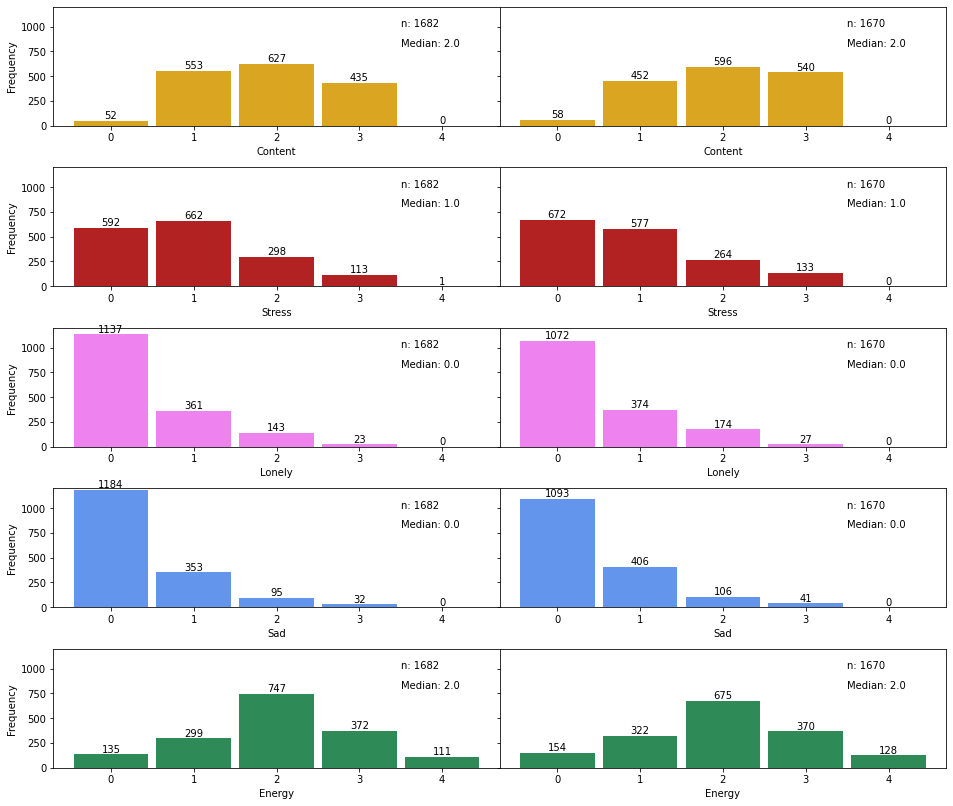

In [8]:
fig, axes = plt.subplots(5,2,figsize=(16,14),sharey='row')
c = 0
for df in [sleep_survey,evening_survey]:
    r = 0
    for question, color in zip(['Content','Stress','Lonely','Sad','Energy'],['goldenrod','firebrick','violet','cornflowerblue','seagreen']):
        ax = axes[r,c]
        n,bins,patches = ax.hist(df[question],bins=[-0.5,0.5,1.5,2.5,3.5,4.5],rwidth=0.9,color=color)
        ax.set_xlabel(question)
        if c == 0:
            ax.set_ylabel('Frequency')
        ax.set_ylim([0,1200])

        ax.text(3.5,1000,f'n: {len(df[question])}')
        ax.text(3.5,800,f'Median: {np.nanmedian(df[question])}')

        label_hist(n, bins, ax)
        
        r += 1
        
    c += 1

plt.subplots_adjust(wspace=0,hspace=0.35)
plt.show()
plt.close()

## Sleep
Sleep portions of the survey includes:
- TST: total sleep time
- SOL: sleep onset latency
- NAW: number of awakenings
- Restful: Likert scale 0-3

In [9]:
import scipy.stats as st

### Aggregate Histogram
Plotting the EMA survey results.

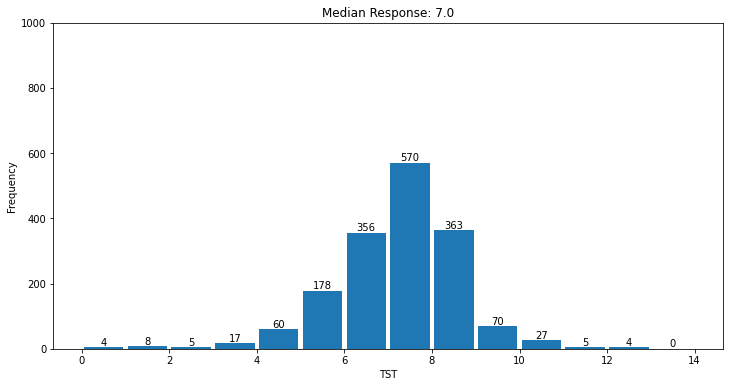

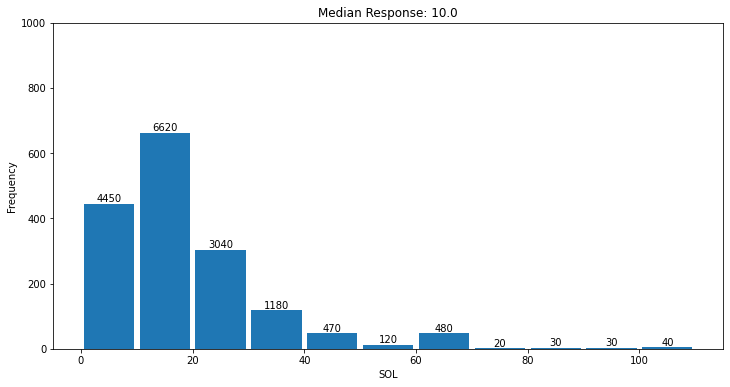

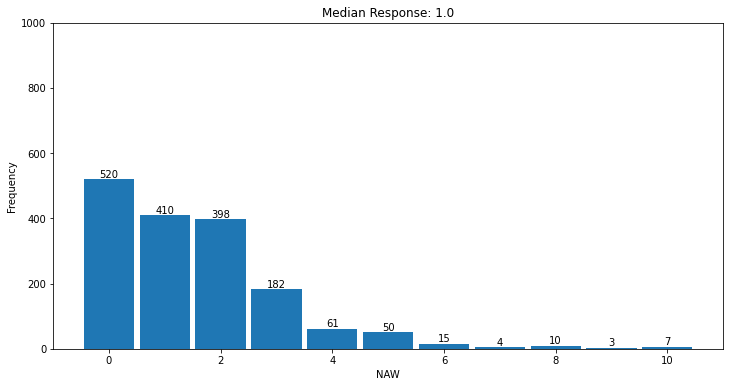

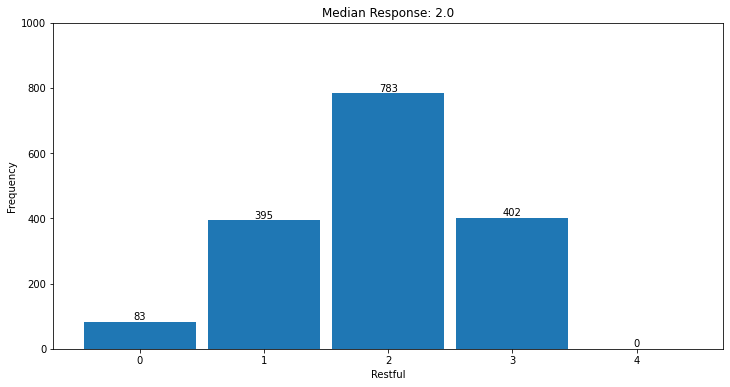

In [10]:
questions = ['TST','SOL','NAW','Restful']
bin_list = [np.arange(0,15,1),
           np.arange(0,120,10),
           np.arange(-0.5,11.5,1),
           [-0.5,0.5,1.5,2.5,3.5,4.5]]

for question, bins in zip(questions, bin_list):
    fig, ax = plt.subplots(figsize=(12,6))
    n,bins,patches = plt.hist(sleep_survey[question],bins=bins,rwidth=0.9,align='mid')
    ax.set_xlabel(question)
    ax.set_ylabel('Frequency')
    ax.set_ylim([0,1000])
    
    ax.set_title(f'Median Response: {np.nanmedian(sleep_survey[question])}')
    
    label_hist(n, bins, ax)
        
    plt.show()
    plt.close()

### Per Participant Responses

In [11]:
first_date = datetime(2020,6,10) # beiwe surveys were fixed this day
end_date = datetime(2020,9,1) # this was the first sampling appointment - some pts might have turned off beiwe
maxDailySurveys = np.busday_count(first_date.date(), end_date.date(), weekmask='Sun Mon Wed Fri')
print(f'Maximum \"Daily\" Surveys: {maxDailySurveys}')
maxWeeklySurveys = np.busday_count(first_date.date(), end_date.date(), weekmask='Sat')
print(f'Maximum Weekly Surveys: {maxWeeklySurveys}')

Maximum "Daily" Surveys: 48
Maximum Weekly Surveys: 12


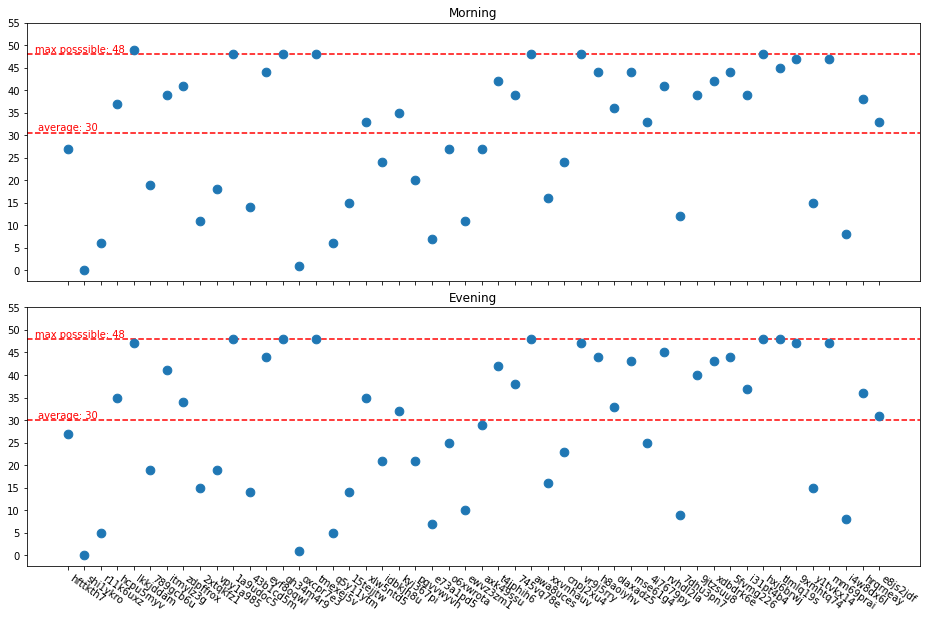

In [12]:
fig, axes = plt.subplots(2,1,figsize=(16,10),sharex='col')
i = 0
for df in [sleep_survey,evening_survey]:
    # Number of surveys submitted
    bid = []
    surveys_submitted = []
    # Looping through beacon participants only
    for beiwe in df['ID'].unique():
        survey_by_beiwe = df[df['ID'] == beiwe]
        survey_by_beiwe = survey_by_beiwe[(survey_by_beiwe.index >= first_date) &
         (survey_by_beiwe.index <= end_date)]
        bid.append(beiwe)
        surveys_submitted.append(len(survey_by_beiwe))

    ax = axes[i]
    # scattering number of surveys submitted per participant
    ax.scatter(bid,surveys_submitted,s=75,zorder=10)

    ax.set_yticks(np.arange(0,60,5))
    plt.xticks(rotation=-35,ha='left')
    # adding average line
    ax.axhline(np.nanmean(surveys_submitted),color='red',linestyle='dashed')
    avg = int(np.nanmean(surveys_submitted))
    ax.text(bid[0],np.nanmean(surveys_submitted),f'average: {avg}',va='bottom',ha='center',color='red')
    #percentage
    ax.axhline(maxDailySurveys,color='red',linestyle='dashed')
    ax.text(bid[0],maxDailySurveys,f'        max posssible: {maxDailySurveys}',va='bottom',ha='center',color='red')
    
    if i == 0:
        ax.set_title('Morning')
    else:
        ax.set_title('Evening')
    
    i+= 1
    
plt.subplots_adjust(hspace=0.1)
plt.savefig('../reports/utx000_initial_update/figures/beiwe-beiwe-number-weekly-surveys.pdf')
plt.show()
plt.close()

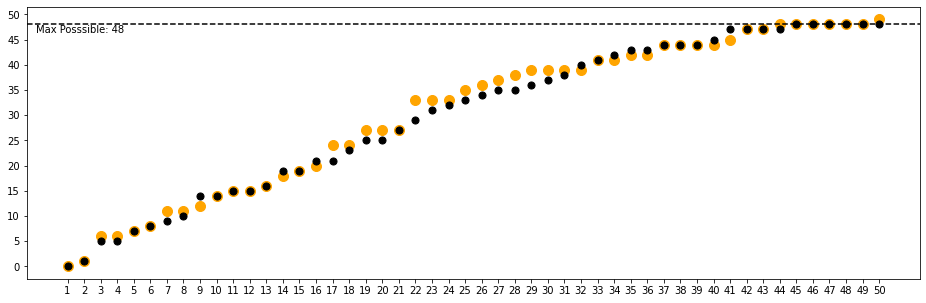

In [13]:
fig, ax = plt.subplots(figsize=(16,5))
temp_dict = dict({})
i = 0
for df, color, size in zip([sleep_survey,evening_survey],['orange','black'],[100,50]):
    # Number of surveys submitted
    bid = []
    surveys_submitted = []
    # Looping through beacon participants only
    for beiwe in df['ID'].unique():
        survey_by_beiwe = df[df['ID'] == beiwe]
        survey_by_beiwe = survey_by_beiwe[(survey_by_beiwe.index >= first_date) &
         (survey_by_beiwe.index <= end_date)]
        bid.append(beiwe)
        surveys_submitted.append(len(survey_by_beiwe))
    temp_dict[f'pts{i}'] = bid
    temp_dict[color] = surveys_submitted
    surveys_submitted.sort()

    # scattering number of surveys submitted per participant
    ax.scatter(bid,surveys_submitted,s=size,color=color)

    ax.set_yticks(np.arange(0,55,5))
    i += 1
    
ax.set_xticklabels(pd.DataFrame(temp_dict).index+1)
#percentage
ax.axhline(maxDailySurveys,color='black',linestyle='dashed')
ax.text(bid[0],maxDailySurveys,f'        Max Posssible: {maxDailySurveys}',va='top',ha='center',color='black')
    
plt.subplots_adjust(hspace=0.1)
plt.savefig('../reports/conferences/BuildSys_2020/beiwe-beiwe-number-weekly-surveys-ordered.pdf')
plt.show()
plt.close()

In [14]:
submission = pd.DataFrame(temp_dict)
submission['orange_pct'] = submission['orange'] / maxDailySurveys * 100
submission['black_pct'] = submission['black'] / maxDailySurveys * 100
cutoffs = pd.DataFrame()
for color in ['orange','black']:
    cutoff_dict = dict({})
    for cutoff in [0,25,50,75,85,95]:
        temp = submission[submission[f'{color}_pct'] >= cutoff]
        cutoff_dict[cutoff] = [len(temp)]

    cutoffs_survey = pd.DataFrame(cutoff_dict)
    cutoffs = cutoffs.append(cutoffs_survey)
    
cutoffs

,0,25,50,75,85,95
0,50,42,34,25,18,9
0,50,42,32,22,18,10


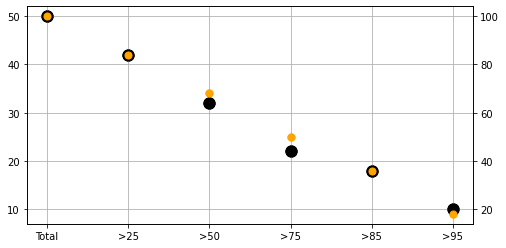

In [15]:
fig, ax = plt.subplots(figsize=(8,4))
for i, size, color in zip([1,0],[125,50],['black','orange']):
    ax.scatter(np.arange(6),cutoffs.iloc[i,:],color=color,s=size)


ax.set_xticks(np.arange(6))
ax.set_xticklabels(['Total','>25','>50','>75','>85','>95'])
#ax.set_ylim([0,60])

ax2 = ax.twinx()
for i, size, color in zip([1,0],[125,50],['black','orange']):
    ax2.scatter(np.arange(6),cutoffs.iloc[i,:]/50*100,color=color,s=size)
    
#ax2.set_ylim([0,100])
ax.grid('both',zorder=1)
   
plt.savefig(f'../reports/conferences/BuildSys_2020/beiwe-beiwe-survey-completeness-combined.pdf')
plt.show()
plt.close()

### Differences in the Day of the Week


Restricted to Beacon Participants Only: False


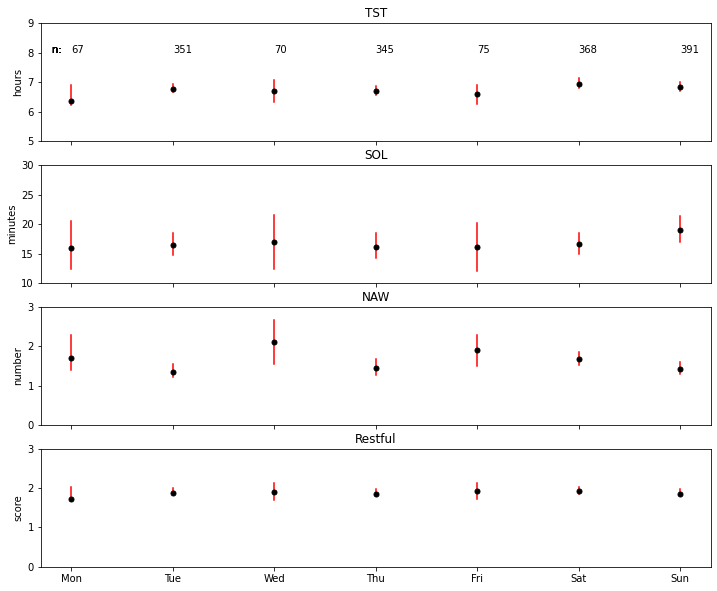

Restricted to Beacon Participants Only: True


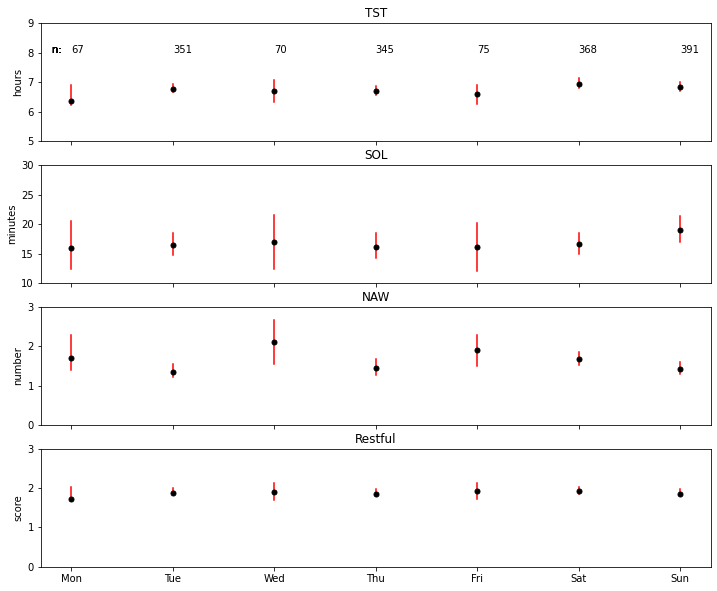

In [16]:
# grouping by night sleep (survey date - 1 day)
sleep_survey['DoW'] = (sleep_survey.index - timedelta(days=1)).strftime('%a')
# all participants
sleep_survey_dow = sleep_survey.groupby(['DoW']).mean()
sleep_survey_dow = sleep_survey_dow.reindex(["Mon", "Tue", "Wed","Thu","Fri","Sat",'Sun'])
# beacon-holding participants only
sleep_survey_restricted = sleep_survey[sleep_survey['ID'].isin(bid)]
sleep_survey_dow_beacon = sleep_survey_restricted.groupby(['DoW']).mean()
sleep_survey_dow_beacon = sleep_survey_dow_beacon.reindex(["Mon", "Tue", "Wed","Thu","Fri","Sat",'Sun'])
# looping through both dataframes
for df, restricted in zip([sleep_survey_dow,sleep_survey_dow_beacon],[False,True]):
    print(f'Restricted to Beacon Participants Only: {restricted}')
    fig, axes = plt.subplots(4,1,figsize=(12,10),sharex=True)
    i=0
    limits = [[5,9],[10,30],[0,3],[0,3]]
    for question, limit, ylabel in zip(['TST','SOL','NAW','Restful'],limits,['hours','minutes','number','score']):

        sleep_survey_dow_plot = df[df[question] >= 0]
        # Scattering for day of week
        axes[i].scatter(sleep_survey_dow_plot.index,sleep_survey_dow_plot[question],s=25,color='black',zorder=10)
        axes[i].set_title(question)
        axes[i].set_ylim(limit)
        axes[i].set_ylabel(ylabel)

        # Adding 95% CI
        for day in sleep_survey['DoW'].unique():
            sleep_survey_by_day = sleep_survey[sleep_survey['DoW'] == day]
            if restricted:
                sleep_survey_by_day = sleep_survey_by_day[sleep_survey_by_day['ID'].isin(bid)]

            sleep_survey_by_day = sleep_survey_by_day[sleep_survey_by_day[question] >= 0]
            ci = st.t.interval(0.95, len(sleep_survey_by_day[question])-1,
                          loc=np.mean(sleep_survey_by_day[question]),
                          scale=st.sem(sleep_survey_by_day[question]))

            axes[i].plot([day,day],ci,color='red',zorder=1) 
            # adding number of surveys on top figure
            if question == 'TST':
                axes[i].text('Mon',8,'n:   ',ha='right')
                axes[i].text(day,8,len(sleep_survey_by_day))
        i += 1

    plt.subplots_adjust(wspace=0,hspace=0.2)
    plt.show()
    plt.close()

### Per Participant Responses

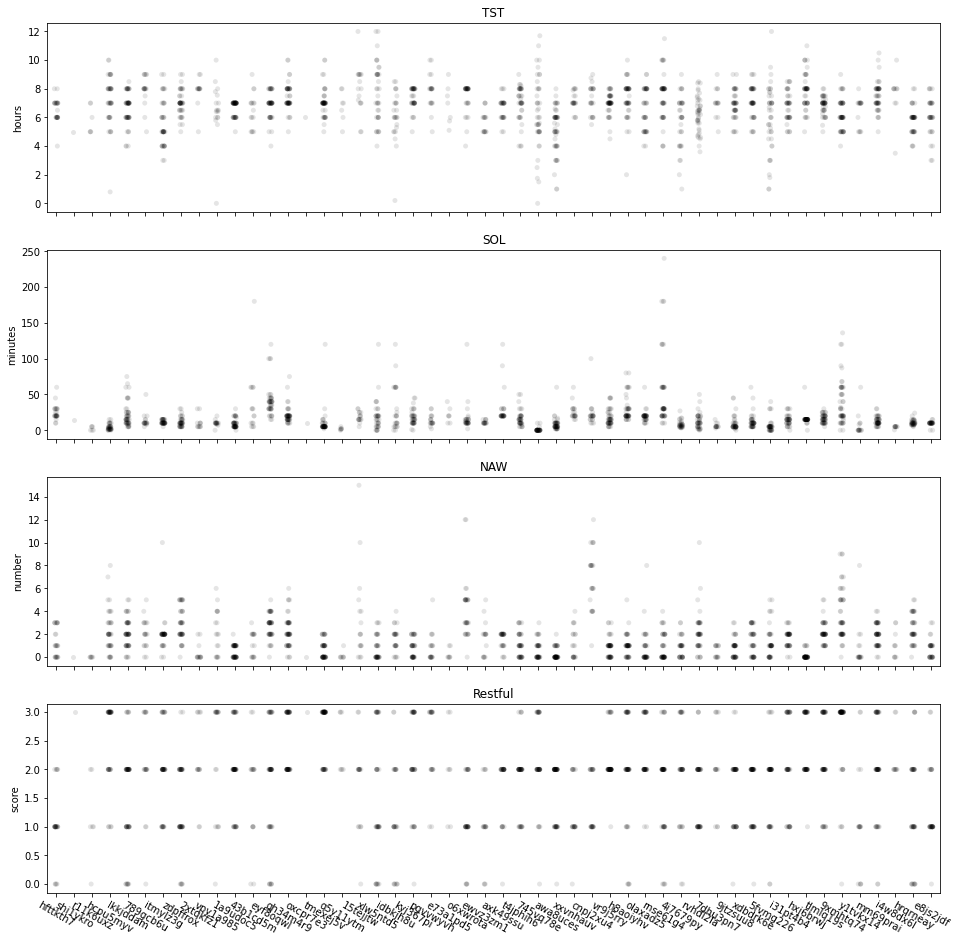

In [17]:
# Sleep metrics
fig, axes = plt.subplots(4,1,figsize=(16,16),sharex=True)
sleep_survey_restricted = sleep_survey[sleep_survey['ID'].isin(bid)]
i = 0
for question, ylabel in zip(['TST','SOL','NAW','Restful'],['hours','minutes','number','score']):
    sleep_survey_restricted_plot = sleep_survey_restricted[sleep_survey_restricted[question] >= 0]
    sns.stripplot(x='ID',y=question,data=sleep_survey_restricted_plot,color='black',alpha=0.1,ax=axes[i])
    axes[i].set_xlabel('')
    axes[i].set_ylabel(ylabel)
    axes[i].set_title(question)
    
    i += 1
    
plt.xticks(rotation=-30)
plt.subplots_adjust(hspace=0.2)
plt.show()
plt.close()

# Analysis on Fully Filtered Dataset
In the following cells, we only consider the data from the fully filtered dataset - that is data from nights when we have GPS confirming pts are home, Fitbit data confirming pts are asleep, and beacon data from their environment.

## Pre-Processing
We have the nights we need to consider, so first we have to filter the overall EMA dataframe by the nights present in the fully filtered beacon data.

In [18]:
ff_df = pd.read_csv('../data/processed/bpeace2-beacon-fb_ema_and_gps_restricted.csv',
                                 index_col=0, parse_dates=[0,-2,-1], infer_datetime_format=True)

Adding date columns to eventually merge on

In [19]:
ff_df['date'] = ff_df['end_time'].dt.date
sleep_survey['date'] = sleep_survey.index.date

Merging the two dataframes to get the correct number of nights.

In [20]:
ff_sleep_survey_df = pd.DataFrame() # dataframe to hold the relevant sleep EMAs
# looping through fully filtered data and merging dataframes on common start times
for pt in ff_df['Beiwe'].unique():
    ff_sleep_pt = sleep_survey[sleep_survey['ID'] == pt]
    ff_pt = ff_df[ff_df['Beiwe'] == pt]
    ff_pt_summary = ff_pt.groupby('date').mean()
    ##ff_pt.drop(['ID'],axis=1,inplace=True)
    
    ff_sleep_survey_df = ff_sleep_survey_df.append(pd.merge(left=ff_sleep_pt,right=ff_pt_summary,left_on='date',right_on='date',how='inner'))

print('Number of nights with EMAs completed:', len(ff_sleep_survey_df))

Number of nights with EMAs completed: 178


In [21]:
ff_sleep_survey_df.head()

,ID,Content,Stress,Lonely,Sad,Energy,TST,SOL,NAW,Restful,...,PM_N_2p5,PM_N_4,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Fitbit,REDCap
0,lkkjddam,1.0,1.0,0.0,1.0,1.0,6.0,20.0,2.0,1.0,...,12.628237,13.446407,13.611750,1.619614,6.297964,10.008931,10.751125,21,25,12
1,lkkjddam,1.0,2.0,0.0,3.0,1.0,7.0,10.0,3.0,1.0,...,15.490433,16.412822,16.599408,1.982984,7.264487,11.446701,12.283143,21,25,12
2,lkkjddam,1.0,1.0,0.0,1.0,2.0,6.0,5.0,0.0,1.0,...,15.162251,16.067154,16.250199,1.941066,7.122249,11.225221,12.045815,21,25,12
3,lkkjddam,1.0,2.0,1.0,2.0,1.0,6.0,20.0,4.0,1.0,...,13.030803,13.880528,14.052236,1.671495,6.529800,10.383996,11.154836,21,25,12
4,lkkjddam,1.0,2.0,1.0,1.0,1.0,6.0,25.0,2.0,1.0,...,16.283555,17.199481,17.384891,2.082057,7.331746,11.483604,12.313976,21,25,12


<div class="alert alert-block alert-warning">
    Somehow we currently have one extra day (178 vs 177) than we should.
</div>

## Summary
The following cells highlight some summary information and illustrate it with figures.

In [22]:
def plot_stacked_hist(df,var,limits,width=1,cmap='coolwarm',by_var='beiwe',save=False,save_dir='../reports/figures/'):
    '''
    Plots a stacked histogram with each color representing a unique individual.
    
    Inputs:
    - df: dataframe of the data
    - var: string specifying the column in the dataframe to plot
    - limits: tuple representing the lower and upper bound on the x-axis
    - width: integer/float for the width of each bin
    - by_var: string specifying the column to color the stacks by
    - save: boolean to save or not
    - save_dr: string representing the location to save the figure if save is True
    
    Returns the axes with the histogram
    '''
    list_to_plot = []
    for pt in df[by_var].unique():
        temp_df = df[df[by_var] == pt]
        list_to_plot.append(temp_df[var].to_list())
    
    colors = cm.get_cmap(cmap, len(list_to_plot))
    fig, ax = plt.subplots(figsize=(8,4))
    n, bins, _ = ax.hist(list_to_plot,bins=np.arange(limits[0],limits[1]+width,width),stacked=True,rwidth=0.9,
            color=colors(np.linspace(0, 1, len(list_to_plot))),edgecolor='black')
    
    for loc in ['right','top']:
        ax.spines[loc].set_visible(False)
    ax.set_ylabel('Count')

    if save == True:
        plt.savefig(f'{save_dir}/bpeace2-{var}-stacked_hist.pdf')
        
    return ax
    

### TST

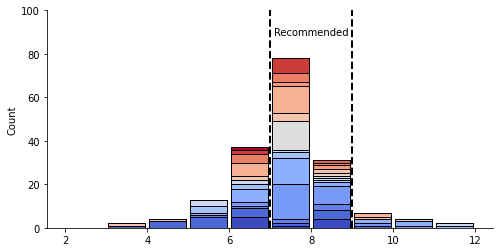

In [45]:
ax = plot_stacked_hist(ff_sleep_survey_df,'TST',[2,12],by_var='ID')
ax.set_ylim([0,100])

ax.axvline(7,color='black',linestyle='dashed',linewidth=2)
ax.axvline(9,color='black',linestyle='dashed',linewidth=2)
ax.text(8,90,"Recommended",ha='center',va='center')

plt.savefig('../reports/figures/bpeace2-beiwe_sleep_duration-stacked_hist.pdf')
plt.show()
plt.close()

### SOL
We have SOL reported by the pts.

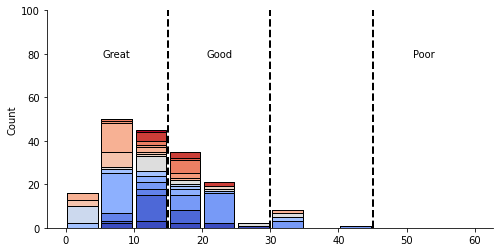

In [41]:
ax = plot_stacked_hist(ff_sleep_survey_df,'SOL',[0,60],width=5,by_var='ID')
ax.set_ylim([0,100])

ax.axvline(15,color='black',linestyle='dashed',linewidth=2)
ax.axvline(30,color='black',linestyle='dashed',linewidth=2)
ax.axvline(45,color='black',linestyle='dashed',linewidth=2)
ax.text(7.5,80,"Great",ha='center',va='center')
ax.text(22.5,80,"Good",ha='center',va='center')
ax.text(52.5,80,"Poor",ha='center',va='center')

plt.savefig('../reports/figures/bpeace2-beiwe_sleep_sol-stacked_hist.pdf')
plt.show()
plt.close()

###  Awakenings

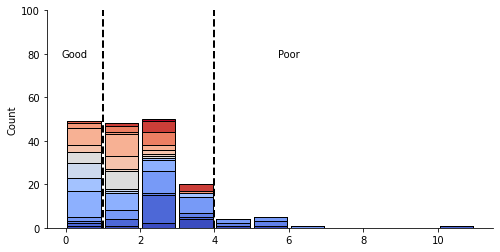

In [42]:
ax = plot_stacked_hist(ff_sleep_survey_df,'NAW',[0,11],width=1,by_var='ID')
ax.set_ylim([0,100])

ax.axvline(1,color='black',linestyle='dashed',linewidth=2)
ax.axvline(4,color='black',linestyle='dashed',linewidth=2)
ax.text(0.25,80,"Good",ha='center',va='center')
ax.text(6,80,"Poor",ha='center',va='center')

plt.savefig('../reports/figures/bpeace2-beiwe_sleep_awakenings-stacked_hist.pdf')
plt.show()
plt.close()

### Restful Score
On a scale of 0-3 (not at all to very much)

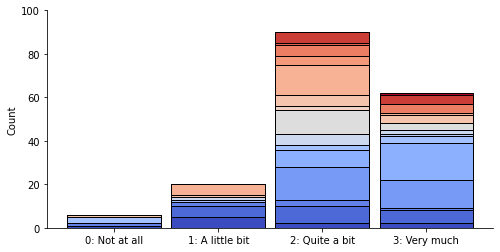

In [44]:
ax = plot_stacked_hist(ff_sleep_survey_df,'Restful',[0,4],width=1,by_var='ID')
ax.set_ylim([0,100])
ax.set_xticks([0.5,1.5,2.5,3.5])
ax.set_xticklabels(['0: Not at all','1: A little bit','2: Quite a bit','3: Very much'])

plt.savefig('../reports/figures/bpeace2-beiwe_sleep_restful-stacked_hist.pdf')
plt.show()
plt.close()